# About Dataset

The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

Single-image, multi-class classification problem
More than 40 classes
More than 50,000 images in total
Large, lifelike database

# 1. Loading Data

In [1]:
#Importing libraries
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from keras.utils import to_categorical
from random import randint

In [2]:
#Loading data
data_folder = "/Users/adlfkl/Desktop/Paidwork/nginx/html/data/opencv_trudne/"
train_df_original = pd.read_csv(data_folder+'Train.csv')
test_df_original = pd.read_csv(data_folder+'Test.csv')
meta_df =  pd.read_csv(data_folder+"Meta.csv") 

train_df_original['Pics'] = [cv2.imread(data_folder+train_df_original['Path'][i]) for i in train_df_original.index]
test_df_original['Pics'] = [cv2.imread(data_folder+test_df_original['Path'][i]) for i in test_df_original.index]
train_df_original.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Pics
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,"[[[56, 51, 46], [56, 51, 48], [54, 51, 50], [5..."
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,"[[[55, 50, 47], [55, 50, 49], [54, 50, 50], [5..."
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,"[[[57, 50, 51], [60, 51, 51], [57, 51, 50], [5..."
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,"[[[54, 49, 49], [55, 50, 49], [55, 50, 48], [5..."
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,"[[[55, 50, 50], [56, 50, 51], [54, 49, 51], [5..."


# 2. EDA

In [3]:
# Checking datasets shapes, missing values, and duplicates
print('Train data shape:',train_df_original.shape,'\nTest data shape:',test_df_original.shape)
print('\nDuplicates in train data:',train_df_original['Pics'].duplicated().sum(),'\nDuplicates in test data:',test_df_original['Pics'].duplicated().sum())
print('\nMissing data in train:\n',train_df_original.isnull().sum(),'\n\nMissing data in test:\n',test_df_original.isnull().sum())


Train data shape: (39209, 9) 
Test data shape: (12630, 9)

Missing data in train:
 Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
Pics       0
dtype: int64 

Missing data in test:
 Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
Pics       0
dtype: int64


In [4]:
print(train_df_original.describe(),"\n")
print(test_df_original.describe())

              Width        Height        Roi.X1        Roi.Y1        Roi.X2  \
count  39209.000000  39209.000000  39209.000000  39209.000000  39209.000000   
mean      50.835880     50.328930      5.999515      5.962381     45.197302   
std       24.306933     23.115423      1.475493      1.385440     23.060157   
min       25.000000     25.000000      0.000000      5.000000     20.000000   
25%       35.000000     35.000000      5.000000      5.000000     29.000000   
50%       43.000000     43.000000      6.000000      6.000000     38.000000   
75%       58.000000     58.000000      6.000000      6.000000     53.000000   
max      243.000000    225.000000     20.000000     20.000000    223.000000   

             Roi.Y2       ClassId  
count  39209.000000  39209.000000  
mean      44.728379     15.788390  
std       21.971145     12.013238  
min       20.000000      0.000000  
25%       30.000000      5.000000  
50%       38.000000     12.000000  
75%       52.000000     25.000000  


Data is of an inconsitent shapes. Imagaes will be resized to (43,43)

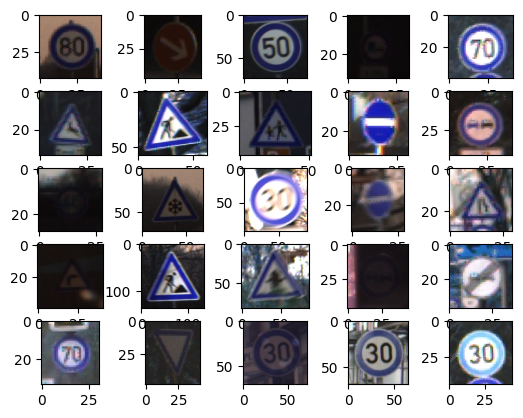

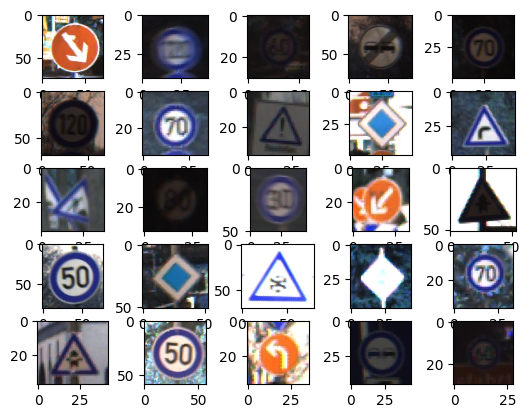

In [5]:
#Visualization of sample pics
def plot_random(df, seed = 1, plot = True):
    random.seed(seed)
    if plot:
        fig, axs = plt.subplots(5,5)
    pics = []
    for x in range (5):
        for y in range (5):
            rand_img = df['Pics'][randint(0,len(df)-1)]
            pics.append(rand_img)
            if plot:
                axs[x,y].imshow(rand_img)
    plt.show()
    return(pics)
random_pics_train = plot_random(train_df_original)
random_pics_test = plot_random(test_df_original)

In [6]:
# enhance contrast
def enhance_contrast(img):

    # converting to LAB color space
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
    #result = np.hstack((img, enhanced_img))
    result = enhanced_img
    return result

In [7]:
# Creating a function that finds lines in a picture
def find_lines(img, return_img = True, preprocess = True):
    if preprocess:
        img = cv2.resize(img,(43,43))
        img_org = img.copy()
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(img,300,500)

    if edges.sum() == 0:
        edges =  cv2.Canny(img,200,400)
        if edges.sum() == 0:
            edges = cv2.Canny(img,100,300)
            if edges.sum() == 0:
                edges = cv2.Canny(img,50,200)
                if edges.sum() == 0:
                    edges = cv2.Canny(img,25,100)
                    if edges.sum() == 0:
                        edges = cv2.Canny(img,10,20)
                        
    lines = cv2.HoughLinesP(edges, 100, np.pi/45, 1)

    if return_img:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(img_org, (x1, y1), (x2, y2), (20, 220, 20), 1)
        return img_org, lines
    
    else:
        return lines

    

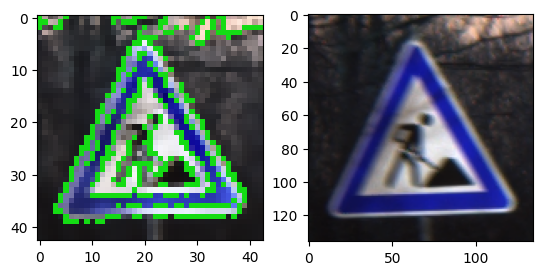

In [8]:
#Checking how enchancing contrast, bilateral blur, and finding lines can infulence the example pic
enchanced = random_pics_train[16]
enchanced = enhance_contrast(enchanced)
enchanced = cv2.bilateralFilter(enchanced,11,41,39)
enchanced, lines = find_lines(enchanced)
fig, axs = plt.subplots(1,2)
axs[0].imshow(enchanced)
axs[1].imshow(random_pics_train[16])

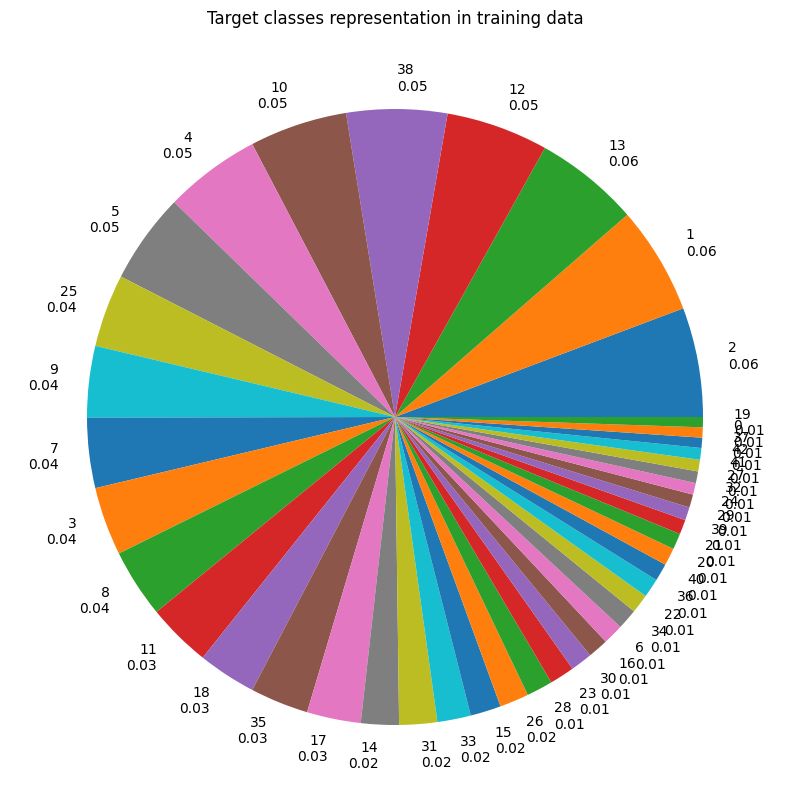

Maximum frequency of data points belonging to the same class: 2250
Minimum frequency of data points belonging to the same class: 210
Maximum difference between target classes representation in train: 2040


In [9]:
#Visualizing classes representation
plt.figure(figsize=(10,10))
plt.pie(train_df_original['ClassId'].value_counts(),labels = [f'{idx}\n{round(train_df_original["ClassId"].value_counts()[idx]/len(train_df_original),2)}' for idx in train_df_original['ClassId'].value_counts().index])
plt.title('Target classes representation in training data')
plt.show()
print(f'Maximum frequency of data points belonging to the same class: {max(train_df_original["ClassId"].value_counts())}')
print(f'Minimum frequency of data points belonging to the same class: {min(train_df_original["ClassId"].value_counts())}')
print(f'Maximum difference between target classes representation in train: {max(train_df_original["ClassId"].value_counts())-min(train_df_original["ClassId"].value_counts())}')

Data is imabalanced. Due to low population of the least frequent classes undersampling is not considered, as it would require deleting too much of data. Therefore, 2 approaches are considered: oversampling, and tree-based model working on the original dataset. 

# 2. Data Prepreocessing
Based on the input from EDA, the following modifications will be applied to data:

1. Resizing images
2. Encahncing contrast of images
3. Applying bilateral filter to images
4. Converting images to a grayscale 
5. Oversampling / modelling robust to class imbalances. 
7. Augmenting some images to improve model's generalizability. 
6. Finding lines on images
7. Normalization

In [10]:
# Creating an oversampler function. It adds an addictional column 'isDuplicate' that indicates which rows were duplicated
def oversampler(df):
    df['isDuplicate'] = [False] * train_df_original.shape[0]
    val_counts = df['ClassId'].value_counts()
    target_len = max(val_counts)

    for cat in val_counts.index:
        current_len = val_counts[cat]

        if current_len < target_len:
            oversample = df[df.ClassId == cat].sample(target_len-current_len,replace = True)
            oversample.isDuplicate = [True] * oversample.shape[0]
            df = pd.concat([df,oversample],ignore_index=True)
    return df

In [11]:
# Testing the oversampler function
oversample_example = oversampler(train_df_original)
print(f'The least frequent class: {min(oversample_example.ClassId.value_counts())}\nThe most frequent class: {max(oversample_example.ClassId.value_counts())}')
print(f'Original number of rows: {train_df_original.shape[0]}; Number of rows after oversampling: {oversample_example.shape[0]}')

The least frequent class: 2250
The most frequent class: 2250
Original number of rows: 39209; Number of rows after oversampling: 96750


After oversampling, number of rows almost doubled. Data will be augmented to avoid overfitting to oversampled images. Augmentation techniques that wil be used here are cropping and rotating.

In [12]:
#Defining a function to randomly crop an image
def randomcrop(img, scale=0.5):
    
    # Crop image
    height, width = int(img.shape[0]*scale), int(img.shape[1]*scale)
    x = random.randint(0, img.shape[1] - int(width))
    y = random.randint(0, img.shape[0] - int(height))
    cropped = img[y:y+height, x:x+width]
    resized = cv2.resize(cropped, (img.shape[1], img.shape[0]))
    return resized

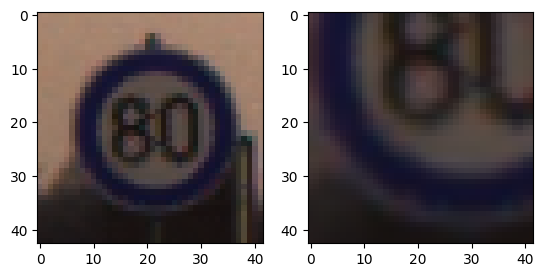

In [13]:
#Testing cropping function
cropped = randomcrop(random_pics_train[0])
fig, ax = plt.subplots(1,2)
ax[0].imshow(random_pics_train[0])
ax[1].imshow(cropped)

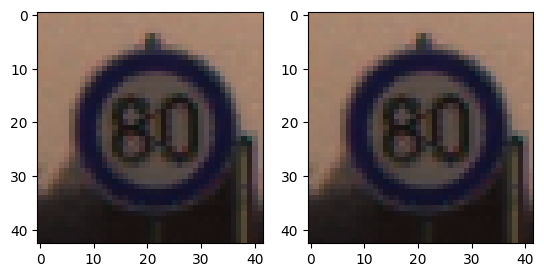

In [104]:
# Creating an augmentatation function. By default, 50% of images will be augmentet. 33% of them will be cropped only, 33% will be rotated only, and 33% will be cropped and rotated.
def augmentate(img, duplicate = False, prob = 0.5, randomcrop_scale = 0.5):
    if random.random() < prob or duplicate:
        choice = random.choice([0,1,2])
        if choice == 0:
            img = randomcrop(img, scale = randomcrop_scale)
        elif choice == 1:
            rotate_direction = random.choice([cv2.ROTATE_180,cv2.ROTATE_90_CLOCKWISE,cv2.ROTATE_90_COUNTERCLOCKWISE])
            img = cv2.rotate(img,rotate_direction)
        else:
            img = randomcrop(img, scale = randomcrop_scale)
            rotate_direction = random.choice([cv2.ROTATE_180,cv2.ROTATE_90_CLOCKWISE,cv2.ROTATE_90_COUNTERCLOCKWISE])
            img = cv2.rotate(img,rotate_direction)
    return img

augmentated = augmentate(random_pics_train[0])
fig, ax = plt.subplots(1,2)
ax[0].imshow(random_pics_train[0])
ax[1].imshow(augmentated)

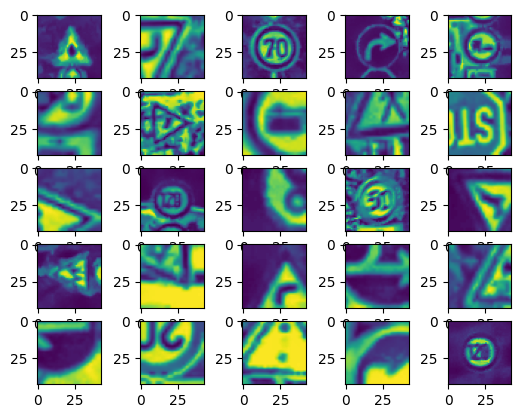

[array([[0.18018018, 0.14864865, 0.1036036 , ..., 0.13513513, 0.13963965,
         0.13963965],
        [0.16216217, 0.13513513, 0.1036036 , ..., 0.13513513, 0.12612613,
         0.12612613],
        [0.13513513, 0.12162162, 0.11261261, ..., 0.13513513, 0.12162162,
         0.11261261],
        ...,
        [0.17567568, 0.14864865, 0.10810811, ..., 0.04954955, 0.04504504,
         0.04504504],
        [0.14864865, 0.12612613, 0.10810811, ..., 0.04054054, 0.04504504,
         0.04504504],
        [0.13063063, 0.11261261, 0.10810811, ..., 0.04504504, 0.04504504,
         0.04504504]], dtype=float32),
 array([[0.6923077 , 0.7025641 , 0.72820514, ..., 0.2769231 , 0.26666668,
         0.26153848],
        [0.6820513 , 0.6923077 , 0.71282053, ..., 0.25641027, 0.26153848,
         0.26153848],
        [0.6615385 , 0.6666667 , 0.6717949 , ..., 0.21025641, 0.24102564,
         0.25641027],
        ...,
        [0.52307695, 0.5794872 , 0.7025641 , ..., 0.17948718, 0.15384616,
         0.14358975

In [105]:
# Creating data preprocessing function
train_df = train_df_original.copy()
test_df = test_df_original.copy()

def process_imgs(df, augment = False, oversample = False, augmentate_prob = 0.5, augmentate_randomcrop_scale = 0.5):
    #Resizing
    df['Pics'] = [cv2.resize(pic,(43,43)) for pic in df['Pics']]

    #Enhancing contrast
    df['Pics'] = [enhance_contrast(pic) for pic in df['Pics']]

    #Bilateral filter 
    df['Pics'] = [cv2.bilateralFilter(pic,11,41,39) for pic in df['Pics']]

    #Converting to a grayscale
    df['Pics'] = [cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY) for pic in df['Pics']]

    #Oversampling
    if oversample:
        df = oversampler(df)

    if augment:
        if oversample:
            df['Pics'] = [augmentate(row.Pics, duplicate = row.isDuplicate, prob = augmentate_prob, randomcrop_scale = augmentate_randomcrop_scale) for i,row in df.iterrows()]
            
        else:
            df['Pics'] = [augmentate(pic,prob = augmentate_prob, randomcrop_scale = augmentate_randomcrop_scale) for pic in df['Pics']]
        
    #Lines
    df['Lines'] = [find_lines(pic,return_img=False, preprocess=False)[:,0,:] for pic in df['Pics']]

    #Normalization ,
    df['Pics'] = [cv2.normalize(pic,None,0,1.0,cv2.NORM_MINMAX,dtype=cv2.CV_32F) for pic in df['Pics']]

    return df[['ClassId','Pics','Lines']]
train_df = process_imgs(train_df,augment=True,oversample=True)
test_df = process_imgs(test_df)
plot_random(train_df)

In [106]:
train_df.head()

,ClassId,Pics,Lines
0,20,"[[0.12328767, 0.12328767, 0.13013698, 0.130136...","[[9, 1, 9, 0], [7, 1, 7, 1], [14, 9, 14, 5], [..."
1,20,"[[0.07692309, 0.07692309, 0.07051283, 0.070512...","[[21, 41, 21, 38], [20, 38, 20, 36], [19, 14, ..."
2,20,"[[0.03999999, 0.03999999, 0.046666656, 0.05999...","[[6, 16, 6, 14], [14, 12, 14, 11], [15, 11, 15..."
3,20,"[[0.04195805, 0.04195805, 0.034965042, 0.06293...","[[6, 2, 6, 0], [5, 10, 5, 3], [6, 12, 6, 10], ..."
4,20,"[[0.14110431, 0.14110431, 0.14723927, 0.153374...","[[29, 20, 29, 19], [28, 25, 28, 25], [1, 33, 1..."


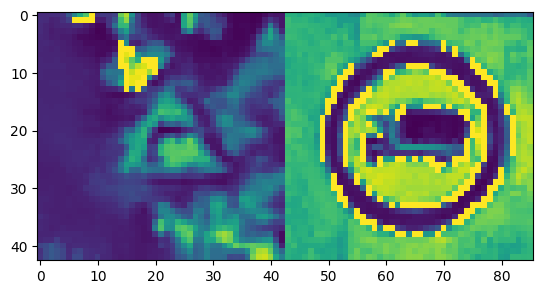

In [107]:
#Drawing lines on a grayscale images
def draw_lines(pic, lines):
    pic = pic.copy()
    for x1, y1, x2, y2 in lines:
            cv2.line(pic, (x1, y1), (x2, y2), 1, 1)
    return pic

train_df['Pics'] = [draw_lines(pic,lines) for pic,lines in zip(train_df.Pics, train_df.Lines)]
test_df['Pics'] = [draw_lines(pic,lines) for pic,lines in zip(test_df.Pics,test_df.Lines)]
plt.imshow(np.hstack([train_df.Pics[0],test_df.Pics[0]]))

# 3. Modelling

In [108]:
train_df.Pics = [np.array([pic]) for pic in train_df.Pics]
test_df.Pics = [np.array([pic]) for pic in test_df.Pics]

In [109]:
# Dividing datasets into features, and labels, and creatig tensor datasets
X_train, y_train, X_test, y_test = train_df.Pics, train_df.ClassId, test_df.Pics, test_df.ClassId

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

IMG_WIDTH = X_train[0].shape[0]
IMG_HEIGHT = X_train[0].shape[1]
OUTPUT_SIZE = y_train.shape[1]

train_data = TensorDataset(torch.FloatTensor(X_train), torch.IntTensor(y_train))
test_data  = TensorDataset(torch.FloatTensor(X_test), torch.IntTensor(y_test))

In [110]:
# Defining DataLoaders and device
batch_size = 50
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [111]:
# Defining NN

class ConvNetwork (torch.nn.Module):
    def __init__(self, output_size = OUTPUT_SIZE, n_channels=1, kernel_size=(3,3)):
        super().__init__()
        self.output_size = output_size
        self.ConvNetwork1 = torch.nn.Conv2d(in_channels = n_channels, out_channels=20, kernel_size=kernel_size)
        self.ReLU = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.ConvNetwork2 = torch.nn.Conv2d(in_channels= 20, out_channels = 50, kernel_size=kernel_size)
        self.fc1 = torch.nn.Linear(in_features=4050, out_features=800)
        self.fc2 = torch.nn.Linear(in_features=800, out_features=OUTPUT_SIZE)
        self.norm1 = torch.nn.BatchNorm2d(20)
        self.norm2 = torch.nn.BatchNorm2d(50)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self,x):
        out = self.ConvNetwork1(x)
        out = self.ReLU(out)
        out = self.maxpool(out)
        out = self.norm1(out)
        out = self.dropout(out)

        out = self.ConvNetwork2(out)
        out = self.ReLU(out)
        out = self.maxpool(out)
        out = self.norm2(out)
        out = self.dropout(out)
        
        out = torch.flatten(out,1)
        out = self.fc1(out)
        out = self.ReLU(out)
        out = self.fc2(out)

        return out

In [112]:
#Defining train and test loops
def train_loop(dataloader, model, loss_fn, optimizer,log = True, log_out = True):
    model.to(device)
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0,0

    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y.argmax(1))
        train_loss += loss_fn(pred,y.argmax(1)).item()
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1) * len(X)
            if log:
                print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

    train_loss /= num_batches
    correct /= size
    
    if log_out:
        print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}\n")
    return 100*correct, train_loss

#Defining test loop
def test_loop(dataloader, model, loss_fn, log = True, valid=False):
    model.eval()
    model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    with torch.no_grad(): 
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y.argmax(1)).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    if log:
        if valid:
            print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
        else:
            print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    return 100*correct, test_loss

Epoch 1
--------------------------------------
loss: 3.801104 [   50/96750]
loss: 3.213773 [ 5050/96750]
loss: 2.953882 [10050/96750]
loss: 2.911782 [15050/96750]
loss: 2.571112 [20050/96750]
loss: 2.670835 [25050/96750]
loss: 2.284051 [30050/96750]
loss: 2.637444 [35050/96750]
loss: 2.295850 [40050/96750]
loss: 2.436243 [45050/96750]
loss: 2.539417 [50050/96750]
loss: 2.230977 [55050/96750]
loss: 1.732984 [60050/96750]
loss: 1.929878 [65050/96750]
loss: 1.978081 [70050/96750]
loss: 1.832680 [75050/96750]
loss: 1.636131 [80050/96750]
loss: 1.749609 [85050/96750]
loss: 1.666194 [90050/96750]
loss: 2.785505 [95050/96750]
Train Error: 
 Accuracy: 37.8%, Avg loss: 2.290566

Test Error: 
 Accuracy: 74.9%, Avg loss: 0.794477

Epoch 2
--------------------------------------
loss: 1.698887 [   50/96750]
loss: 1.824950 [ 5050/96750]
loss: 1.702837 [10050/96750]
loss: 1.657598 [15050/96750]
loss: 1.622262 [20050/96750]
loss: 1.911105 [25050/96750]
loss: 1.418557 [30050/96750]
loss: 1.448740 [3505

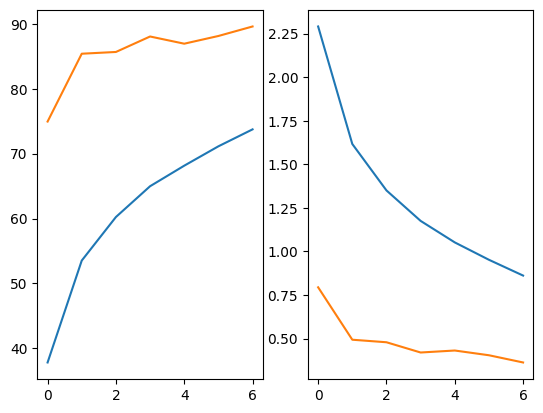

In [113]:
# Test run
lr = 0.001
epochs = 7
model = ConvNetwork()

train_accs = []
train_loss = []

test_accs = []
test_loss =[]

for e in range(epochs):
    print(f'Epoch {e+1}\n--------------------------------------')
    tra,trl = train_loop(train_loader,model,torch.nn.CrossEntropyLoss(),torch.optim.Adam(model.parameters(), lr=lr))
    ta, tl = test_loop(test_loader,model,torch.nn.CrossEntropyLoss())

    train_accs.append(tra)
    train_loss.append(trl)

    test_accs.append(ta)
    test_loss.append(tl)

fig, axs = plt.subplots(1,2)
axs[0].plot(train_accs)
axs[0].plot(test_accs)

axs[1].plot(train_loss)
axs[1].plot(test_loss)
plt.show()

In [115]:
#Testing performance for 10 runs of 10 epochs

lr = 0.001
epochs = 10

valid_accs = []
valid_loss = []

train_accs = []
train_loss = []

for i in range(5):
    print(f'Iteration {i+1}\n--------------------------------------')
    model = ConvNetwork()

    valid_accs_temp = []
    valid_loss_temp = []
    train_accs_temp = []
    train_loss_temp = []

    for e in range(epochs):
        t_acc,t_l = train_loop(train_loader,model,torch.nn.CrossEntropyLoss(),torch.optim.Adam(model.parameters(), lr=lr),log=False, log_out=False)
        v_acc,v_l = test_loop(test_loader,model,torch.nn.CrossEntropyLoss(),log=False)

        valid_accs_temp.append(v_acc)
        valid_loss_temp.append(v_l)
        train_accs_temp.append(t_acc)
        train_loss_temp.append(t_l)

    valid_accs.append(valid_accs_temp)
    valid_loss.append(valid_loss_temp)
    train_accs.append(train_accs_temp)
    train_loss.append(train_loss_temp)
    print(f"    Final accuracy on validation:{valid_accs_temp[len(valid_accs_temp)-1]}")
        

Iteration 1
--------------------------------------
    Final accuracy on validation:90.39588281868566
Iteration 2
--------------------------------------
    Final accuracy on validation:89.42201108471892
Iteration 3
--------------------------------------
    Final accuracy on validation:87.84639746634996
Iteration 4
--------------------------------------
    Final accuracy on validation:90.1741884402217
Iteration 5
--------------------------------------
    Final accuracy on validation:89.63578780680919


Max final accuracy on validation: 90.39588281868566
Avg final accuracy on validation: 89.4948535233571
Minimum difference in final accuracy between training and validation for models that performed better than 60% accuracy on both: -12.931283335481524


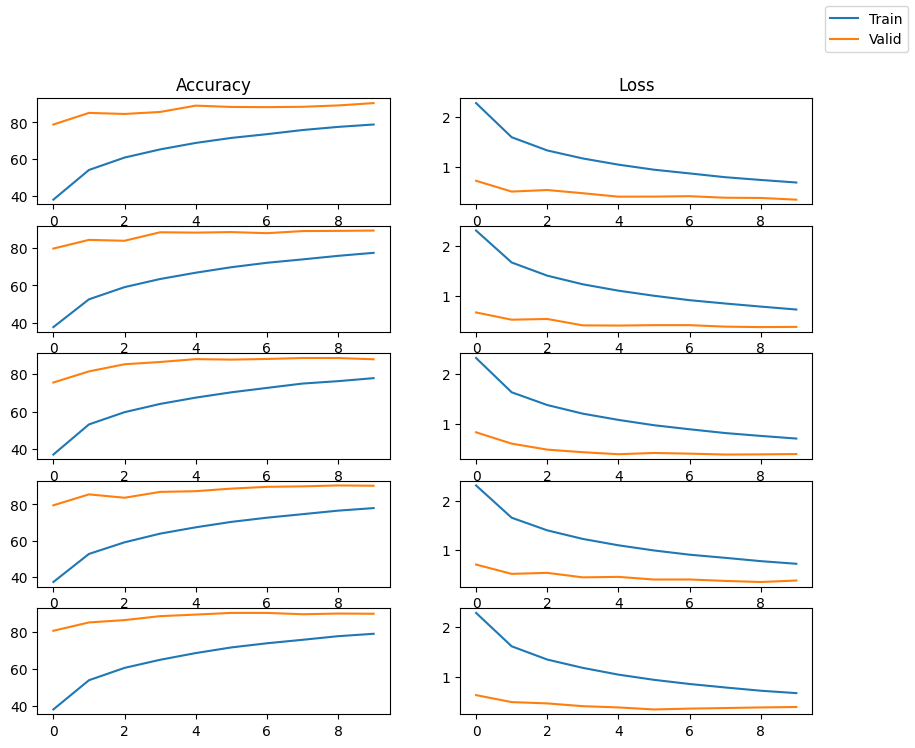

In [116]:
#Visualizing model performance across 10 learnings of 10 epochs
fig, axs = plt.subplots(5,2)
for i, b in enumerate(zip(train_accs,train_loss,valid_accs,valid_loss)):
    axs[i,0].plot(b[0],label = 'Train')
    axs[i,0].plot(b[2],label = 'Valid')
    axs[i,1].plot(b[1],label = 'Train')
    axs[i,1].plot(b[3],label = 'Valid')
    axs[0,1].set_title('Loss')
    axs[0,0].set_title('Accuracy')
fig.legend(['Train','Valid'])
fig.set_size_inches(10,8)
print(f"Max final accuracy on validation: {max([x[epochs-1] for x in valid_accs])}")
print(f"Avg final accuracy on validation: {np.mean([x[epochs-1] for x in valid_accs])}")
print(f'Minimum difference in final accuracy between training and validation for models that performed better than 60% accuracy on both: {min([x[epochs-1] - y[epochs-1] for x in train_accs if x[epochs-1]>60 for y in valid_accs if y[epochs-1]>60])}')

As it can be seen, the model performs well on both dataset. Considering the differences in loss between test, and train datasets it can be concluded that test set is easier to predict than the training set. It is not surprising, as test set is not augmented.